In [1]:
import pyro
import torch
pyro.set_rng_seed(101)

import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt

import numpy as np

In [2]:
prob_dict = {
    'health': torch.tensor([0.6,0.4]),
    'blood_pressure': torch.tensor([[0.4,0.2,0.4],[0.1,0.8,0.1]]),
    'blood_oxygen': torch.tensor([[0.2,0.6,0.2],[0.02,0.08,0.9]]),
    'tempreture': torch.tensor([[0.2,0.4,0.4],[0.1,0.8,0.1]]),
    'doctor1': torch.tensor([[[0.9,0.1],[0.8,0.2],[0.6,0.4]],
                             [[0.9,0.1],[0.7,0.3],[0.05,0.95]],
                             [[0.9,0.1],[0.75,0.25],[0.6,0.4]]]),
    'doctor2': torch.tensor([[[0.8,0.2],[0.6,0.4],[0.9,0.1]],
                             [[0.8,0.2],[0.05,0.95],[0.9,0.1]],
                             [[0.9,0.1],[0.6,0.4],[0.9,0.1]]]),
    'action': torch.tensor([[[0.99,0.01],[0.7,0.3]],
                           [[0.6,0.4],[0.05,0.95]]])
}

In [3]:
label_dict = {
    'health': ['not health', 'health'],
    'blood_pressure': ['low', 'normal', 'high'],
    'blood_oxygen': ['very low', 'low', 'normal'],
    'tempreture': ['low', 'normal', 'high'],
    'doctor1': ['take action', 'no action'],
    'doctor2': ['take action', 'no action'],
    'action': ['take action', 'no action']
}

In [4]:
def model():
    h = pyro.sample("h", dist.Categorical(prob_dict['health']))
    bp = pyro.sample("bp", dist.Categorical(prob_dict['blood_pressure'][h]))
    bo = pyro.sample("bo", dist.Categorical(prob_dict['blood_oxygen'][h]))
    t = pyro.sample("t", dist.Categorical(prob_dict['tempreture'][h]))
    d1 = pyro.sample("d1", dist.Categorical(prob_dict['doctor1'][bp][bo]))
    d2 = pyro.sample("d2", dist.Categorical(prob_dict['doctor2'][bp][t]))
    a = pyro.sample("a", dist.Categorical(prob_dict['action'][d1][d2]))
    
    return{'h': h, 'bp': bp, 'bo': bo, 't': t, 'd1': d1, 'd2': d2, 'a': a}

print(model())

{'h': tensor(0), 'bp': tensor(2), 'bo': tensor(1), 't': tensor(1), 'd1': tensor(0), 'd2': tensor(1), 'a': tensor(0)}


### calculate the causal effect by adjusting for health.

P(not health | action = take action) = 0.784
P(not health | action = no action) = 0.216
P(health | action = take action) = 0.364
P(health | action = no action) = 0.636


Text(0.5, 1.0, 'P(health | action = no action) = 0.636')

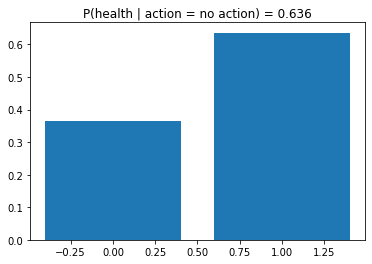

In [5]:
probs = []
for a in range(2):
    p = 0    
    h_model = pyro.condition(model, data={'a': torch.tensor(a)})
    h_posterior = pyro.infer.Importance(h_model, num_samples=1000).run()
    h_marginal = EmpiricalMarginal(h_posterior,"h")
    h_samples = [h_marginal().item() for _ in range(1000)]
    h_counts = np.unique(h_samples, return_counts=True)
    p0 = h_counts[1][0] / 1000
    p1 = h_counts[1][1] / 1000
    probs.append([p0,p1])

print('P(not health | action = take action) = ' + str(probs[0][0]))
print('P(not health | action = no action) = ' + str(probs[0][1]))
print('P(health | action = take action) = ' + str(probs[1][0]))
print('P(health | action = no action) = ' + str(probs[1][1]))

plt.bar(h_counts[0], h_counts[1]/1000, align='center')
plt.title('P(health | action = no action) = ' + str(probs[1][1]))

### Use `pyro.do` to calculate the causal effect

In [6]:
prob_do = []
for h in range(2):
    p = 0
    do_model = pyro.do(model, data={'h': torch.tensor(h)})
    a_sample_do_h = [do_model()['a'].item() for _ in range(1000)]
    prob_a1_do_h = sum(a_sample_do_h) / 1000
    prob_do.append(prob_a1_do_h)

print('P(action = take action | do(health = not health)) = ' + str(1 - prob_do[0]))
print('P(action = no action | do(health = not health)) = ' + str(prob_do[0]))
print('P(action = take action | do(health = health)) = ' + str(1 - prob_do[1]))
print('P(action = no action | do(health = health)) = ' + str(prob_do[1]))

P(action = take action | do(health = not health)) = 0.757
P(action = no action | do(health = not health)) = 0.243
P(action = take action | do(health = health)) = 0.31699999999999995
P(action = no action | do(health = health)) = 0.683
